In [1]:
!pip install scikit-learn==1.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 53.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2


In [2]:
!pip install lazypredict

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from joblib import dump
import itertools
import matplotlib.pyplot as plt
import numpy as np
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
rice_df = pd.read_excel('/content/rice_w2vec_3mer_dataset.xlsx')
rice_df = rice_df.drop(['circName','tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)

In [5]:
maize_df = pd.read_excel('maize_w2vec_3mer_dataset.xlsx')
maize_df = maize_df.drop(['circName','tissue','chr','start','end','strand','start_anno', 'circID',	'gene', 'isoform', 'width', 'detection_score', 'stress_detection_score', 'end_anno', 'antisense', 'algorithm', 'seq', 'exonSeq', 'predAA', 'miRNA','superCircRNARegion'], axis=1)

In [6]:
df = rice_df._append(maize_df, ignore_index = True)

In [7]:
df_multiclass = df.query('stress == "-" or stress == "drought" or  stress == "cold"').replace('drought', 1).replace('cold', 2).replace('-', 0)

### Training and Testing Models

In [38]:
# Define X and y (target) variables
X = df_multiclass.drop(['stress'], axis=1)
y = df_multiclass['stress']

In [39]:
X.head(2)

,wc_3mer_1,wc_3mer_2,wc_3mer_3,wc_3mer_4,wc_3mer_5,wc_3mer_6,wc_3mer_7,wc_3mer_8,wc_3mer_9,wc_3mer_10,...,wc_3mer_55,wc_3mer_56,wc_3mer_57,wc_3mer_58,wc_3mer_59,wc_3mer_60,wc_3mer_61,wc_3mer_62,wc_3mer_63,wc_3mer_64
0,-8.66,-17.17,-20.12,10.61,-0.19,1.57,3.90,7.62,-2.83,13.90,...,-21.98,-12.45,-8.38,-9.52,28.57,7.25,-18.07,-6.67,-3.78,1.30
1,-4.62,-42.06,-73.49,-51.22,83.97,-47.22,-20.22,29.19,-17.14,37.22,...,24.44,-68.49,20.16,14.18,81.44,-4.52,21.87,-10.53,-39.17,63.34


In [40]:
y.value_counts()

,count
stress,
0,70996
1,12030
2,5724


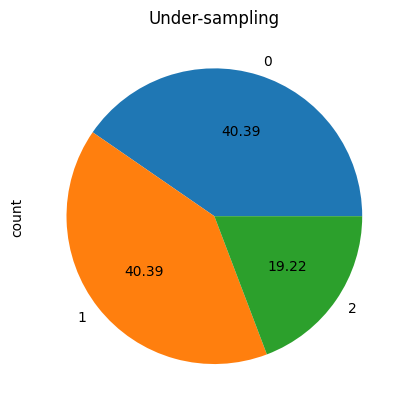

In [41]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy = {0: 12030, 1: 12030, 2: 5724})

X_res, y_res = rus.fit_resample(X, y)

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Under-sampling")

In [42]:
y_res.value_counts()

,count
stress,
0,12030
1,12030
2,5724


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=29)

In [44]:
model_lgb = lgb.LGBMClassifier(random_state=29)
model_lgb.fit(X_train, y_train)

y_pred_lgb = model_lgb.predict(X_test)
report = classification_report(y_test, y_pred_lgb)
print(report)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 23827, number of used features: 64
[LightGBM] [Info] Start training from score -0.909160
[LightGBM] [Info] Start training from score -0.903551
[LightGBM] [Info] Start training from score -1.650213
              precision    recall  f1-score   support

           0       0.71      0.58      0.64      2431
           1       0.76      0.93      0.84      2377
           2       0.65      0.59      0.62      1149

    accuracy                           0.72      5957
   macro avg       0.71      0.70      0.70      5957
weighted avg       0.72      0.72      0.71      5957



In [45]:
from sklearn.ensemble import RandomForestClassifier

modelrf = RandomForestClassifier(random_state=29)
modelrf.fit(X_train, y_train)

y_pred_rf = modelrf.predict(X_test)
report = classification_report(y_test, y_pred_rf)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.60      0.65      2431
           1       0.76      0.92      0.83      2377
           2       0.67      0.59      0.63      1149

    accuracy                           0.73      5957
   macro avg       0.71      0.70      0.70      5957
weighted avg       0.72      0.73      0.72      5957



In [47]:
from sklearn.ensemble import ExtraTreesClassifier

modelext = ExtraTreesClassifier(random_state=29)
modelext.fit(X_train, y_train)

y_pred_ext = modelext.predict(X_test)
report = classification_report(y_test, y_pred_ext)
print(report)

              precision    recall  f1-score   support

           0       0.71      0.60      0.65      2431
           1       0.76      0.92      0.83      2377
           2       0.67      0.59      0.63      1149

    accuracy                           0.73      5957
   macro avg       0.71      0.70      0.70      5957
weighted avg       0.72      0.73      0.72      5957

